# 가전제품 라벨 OCR 인식 향상을 위한 이미지 전처리 파이프라인

가전제품 라벨 이미지 인식을 개선하기 위해 기울기 보정, 노이즈 제거, 문자 대비 향상을 수행하는 이미지 전처리 파이프라인입니다. 이 파이프라인은 가전제품 라벨과 같이 텍스트가 포함된 이미지를 대상으로 하며, 각 단계의 중간 결과를 번호가 매겨진 prefix(예: `1_1_grayscale.jpg`)로 저장합니다. 최종 결과는 Matplotlib을 사용하여 처리 흐름을 시각화합니다.

## 목표
- 이미지의 기울어짐을 바로잡아 텍스트를 수평으로 정렬함.
- 이미지의 노이즈를 제거하여 선명도를 향상시킴.
- 문자 대비를 강화하여 가독성을 높임.
- 처리 파이프라인의 단계를 시각화함.

## 의존성
```sh
pip install opencv-python numpy matplotlib
```
혹은
- OpenCV (`pip install opencv-python`)
- NumPy (`pip install numpy`)
- Matplotlib (`pip install matplotlib`)

## 입력
- 이미지 파일 (예: `ref-tilt.jpg`). 코드 내의 경로 자리표시자를 실제 이미지 경로로 교체해야 함.

## 출력
- 중간 처리 결과 이미지들이 `outputs/`에 저장됨.
- 모든 처리 단계를 보여주는 Matplotlib 시각화 결과 제공됨.

## 0. Setup and Imports

필요한 라이브러리를 임포트하고, 중간 결과 이미지를 저장할 출력 디렉토리를 설정함.

In [1]:
import cv2
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt

# 사용할 이미지 경로 지정
input_image = "ref-tilt.jpg"

# 중간 결과 이미지를 저장할 출력 디렉토리 생성
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

## Step 1: Skew Correction

`correct_skew` 함수는 허프 변환(Hough Transform)을 사용하여 직선을 검출하고, 이로부터 이미지의 평균 기울기 각도를 계산하여 이미지를 수평으로 회전시킴. 중간 결과물(그레이스케일 이미지, 엣지, 검출된 직선, 보정된 이미지)은 `1_` prefix로 저장됨.

In [2]:
def correct_skew(image, step_prefix="1"):
    """
    Hough 변환을 이용해 이미지의 기울기를 감지하고 보정함.
    그레이스케일, 엣지 검출, 직선 시각화, 보정된 이미지 등을 저장함.
    보정된 이미지와 저장된 파일 경로 리스트를 반환함.
    """
    # 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_path = f"{output_dir}/{step_prefix}_1_grayscale.jpg"
    cv2.imwrite(gray_path, gray)

    # 엣지 검출 (Canny)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    edges_path = f"{output_dir}/{step_prefix}_2_edges.jpg"
    cv2.imwrite(edges_path, edges)

    # Hough 변환으로 직선 검출
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    if lines is None:
        raise ValueError("기울기 보정을 위한 직선이 검출되지 않음")

    # 검출된 직선에서 각도 추정
    angles = []
    line_image = image.copy()
    for rho, theta in lines[:, 0]:
        angle = (theta * 180 / np.pi) - 90  # 도 단위로 변환 후 기준 보정
        if abs(angle) < 45:  # 수평에 가까운 직선만 필터링
            angles.append(angle)
            # 직선 시각화
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    lines_path = f"{output_dir}/{step_prefix}_3_lines.jpg"
    cv2.imwrite(lines_path, line_image)

    if not angles:
        raise ValueError("기울기 계산에 사용할 유효한 직선이 없음")

    # 중앙값 각도로 기울기 추정
    skew_angle = np.median(angles)
    print(f"검출된 기울기 각도: {skew_angle:.2f}도")

    # 회전을 통해 이미지 기울기 보정
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, skew_angle, 1.0)
    corrected = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    corrected_path = f"{output_dir}/{step_prefix}_4_corrected.jpg"
    cv2.imwrite(corrected_path, corrected)

    return corrected, [gray_path, edges_path, lines_path, corrected_path]

## Step 2: Noise Suppression

`suppress_noise` 함수는 그레이스케일 이미지에 가우시안 블러(Gaussian Blur)를 적용하여 고주파 노이즈를 감소시킴. 결과 이미지는 `2_` prefix로 저장됨.

In [3]:
def suppress_noise(image, step_prefix="2"):
    """
    그레이스케일 이미지에 가우시안 블러를 적용하여 노이즈를 억제함.
    블러 처리된 이미지를 저장하고, 해당 이미지와 파일 경로를 반환함.
    """
    # 그레이스케일 변환 (필요한 경우)
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # 가우시안 블러 적용
    denoised = cv2.GaussianBlur(gray, (5, 5), 0)
    denoised_path = f"{output_dir}/{step_prefix}_denoised.jpg"
    cv2.imwrite(denoised_path, denoised)

    return denoised, [denoised_path]

## Step 3: Contrast Enhancement

`enhance_contrast` 함수는 CLAHE(제한 대비 적응 히스토그램 평활화)와 적응형 임계처리를 적용하여 문자 대비를 강화하고 이미지를 이진화함. 결과 이미지는 `3_` prefix로 저장됨.

In [4]:
def enhance_contrast(image, step_prefix="3"):
    """
    CLAHE와 적응형 임계처리를 이용하여 문자 대비를 향상시킴.
    대비 강화 이미지와 이진화 이미지를 저장하며, 이진화 이미지와 파일 경로들을 반환함.
    """
    # 그레이스케일 여부 확인 후 변환
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # CLAHE 적용 (국지적 대비 향상)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_enhanced = clahe.apply(gray)
    contrast_path = f"{output_dir}/{step_prefix}_1_contrast_enhanced.jpg"
    cv2.imwrite(contrast_path, contrast_enhanced)

    # 적응형 임계값 처리로 이진화
    binary = cv2.adaptiveThreshold(
        contrast_enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    binary_path = f"{output_dir}/{step_prefix}_2_binary.jpg"
    cv2.imwrite(binary_path, binary)

    return binary, [contrast_path, binary_path]

## Visualization

`display_pipeline` 함수는 모든 처리 단계를 Matplotlib 그리드 형태로 시각화함.

In [5]:
def display_pipeline(images, titles, save_path=None):
    """
    Matplotlib을 사용하여 처리 파이프라인을 시각화함.
    이미지와 타이틀 리스트를 받아 화면에 표시하며,
    save_path가 지정되면 해당 경로에 저장함.
    """
    n = len(images)
    plt.figure(figsize=(8, 5))
    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(2, (n + 1) // 2, i)
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.IMREAD_COLOR))
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()

    # 저장 경로가 지정된 경우 저장
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

## Main Pipeline

`process_image` 함수는 전체 파이프라인의 흐름을 관리하며, 각 처리 단계를 호출하고 결과를 시각화함.

검출된 기울기 각도: -18.00도


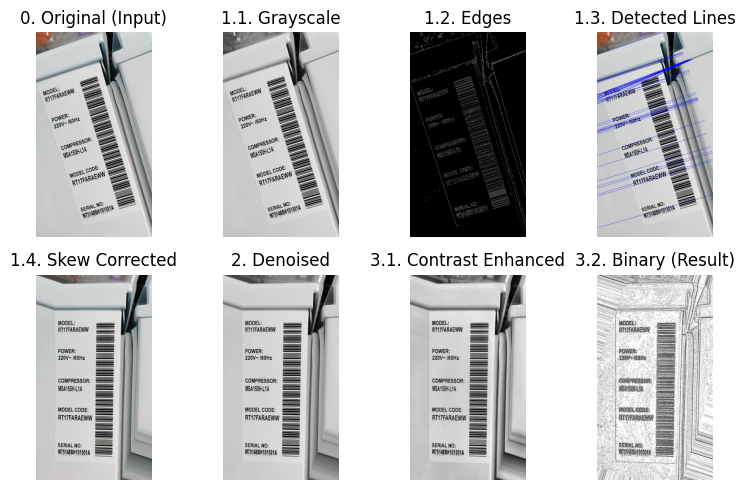

이미지 처리 완료. 'outputs' 에서 결과 확인 가능.


In [6]:
def process_image(image_path):
    """
    이미지를 기울기 보정, 노이즈 억제, 대비 향상 순서로 처리하고,
    각 단계의 결과를 시각화하는 메인 함수.
    """
    # 이미지 불러오기
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"이미지를 불러올 수 없습니다: {image_path}")

    # 각 처리 단계 실행
    original_image_path = input_image
    corrected, skew_paths = correct_skew(image, "1")
    denoised, noise_paths = suppress_noise(corrected, "2")
    binary, contrast_paths = enhance_contrast(denoised, "3")

    # 시각화를 위한 이미지 및 타이틀
    all_paths = [original_image_path] + skew_paths + noise_paths + contrast_paths
    titles = [
        "0. Original (Input)",
        "1.1. Grayscale", "1.2. Edges", "1.3. Detected Lines","1.4. Skew Corrected",
        "2. Denoised",
        "3.1. Contrast Enhanced", "3.2. Binary (Result)"
    ]
    images = [cv2.imread(path) for path in all_paths]

    # 파이프라인 시각화
    display_pipeline(images, titles, save_path="pipeline_output.png")

    return binary

# 파이프라인 실행
try:
    final_image = process_image(input_image)
    print(f"이미지 처리 완료. '{output_dir}' 에서 결과 확인 가능.")
except Exception as e:
    print(f"오류 발생: {e}")

## Results

파이프라인은 `outputs/` 디렉토리에 다음과 같은 결과물을 생성함:
- `1_1_grayscale.jpg`: 입력 이미지를 그레이스케일로 변환한 이미지
- `1_2_edges.jpg`: 기울기 검출을 위한 엣지 검출 이미지
- `1_3_lines.jpg`: 검출된 직선을 빨간 선으로 시각화한 이미지
- `1_4_corrected.jpg`: 기울기 보정 완료된 이미지
- `2_denoised.jpg`: 노이즈 억제 처리된 이미지
- `3_1_contrast_enhanced.jpg`: CLAHE로 대비 향상된 이미지
- `3_2_binary.jpg`: 최종 이진화된 문자 강조 이미지
Matplotlib 시각화 결과는 위에 표시됨.

## Notes
- **파라미터 조정**: 특정 이미지에 맞게 가우시안 블러 `(5, 5)`, CLAHE의 `clipLimit`, 임계처리 블록 크기(`11`) 및 상수(`2`) 등의 값을 조정 가능함.
- **오류 처리**: 이미지 로드 실패나 직선 검출 실패에 대한 예외 처리가 포함되어 있음.
- **향후 확장**: 실제 이미지를 제공하면 추가 개선(예: OCR 통합, 고급 노이즈 제거 기법 등)을 적용 가능함.